# Spike and Slab examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os,sys,time

sys.path.insert(1, '../../src/')
import madmix
import madmix_aux
import gibbs
from concrete import *
import dequantization
import meanfield
import aux

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
fig_path='fig/'
fig_path='../../../madmix-tex/fig/'

In [2]:
def sas_lposterior(pi,theta,tau2,sigma2,beta,x,y):
    """
    Evaluate the posterior log density of a spike and slab model
    K = # of covariates
    B = # of points to evaluate log pdf at
    
    Inputs:
        pi     : (K,B) array, inclusion indicators of regression coefficients (one of {0,1})
        theta  : (B,) array, Categorical probs
        tau2   : (B,) array, beta variances
        sigma2 : (B,) array, obs variances
        beta   : (K,B) array, regression coefficients
        x      : (N,K) array, covariates (N is no. of observations, K is no. of covariates)
        y      : (N,) array, observations
    
    Outputs:
        lp     : (B,) array, posterior 
    """
    K,B = pi.shape
    N = x.shape[0]
    
    # set hyperparams
    a,b=1.,1.
    a1,a2=0.1,0.1
    s=0.5
    
    lp  = np.zeros(B)
    lp += stats.beta(a,b).logpdf(theta)
    lp += stats.invgamma(a=0.5,scale=s**2/2).logpdf(tau2)
    lp += stats.gamma(a=a1,scale=1./a2).logpdf(sigma2)
    lp += np.sum(np.log(theta)*pi + np.log1p(-theta)*(1-pi),axis=0)
    lp += -0.5*K*np.log(2*np.pi*sigma2*tau2)-0.5*np.sum(beta**2,axis=0)/sigma2*tau2
    lp += -0.5*np.log(2*np.pi*sigma2) # log likelihood part 1
    lp += -0.5*np.sum(y[None,:]-np.squeeze(np.matmul(x[None,:,:],beta.T[:,:,None])),axis=1)/sigma2 # ll part 2
    
    return lp

## Prostate cancer data

In [3]:
prst_dat_raw = pd.read_table('https://hastie.su.domains/ElemStatLearn/datasets/prostate.data')
prst_dat_raw

,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
92,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [15]:
# normalize data
prst_dat_x = np.array(prst_dat_raw[prst_dat_raw.columns.difference(['Unnamed: 0','lpsa','train'])])
prst_dat_x = (prst_dat_x-np.mean(prst_dat_x,axis=1)[:,None])/np.std(prst_dat_x,axis=1)[:,None]
prst_dat_y = np.array(prst_dat_raw['lpsa'])
prst_dat_y = (prst_dat_y-np.mean(prst_dat_y))/np.std(prst_dat_y)
K = prst_dat_x.shape[1]

In [5]:
# save data
np.savetxt("dat/prst_dat_x.csv", prst_dat_x, delimiter=",")
np.savetxt("dat/prst_dat_y.csv", prst_dat_y, delimiter=",")

### Gibbs sampling

In [25]:
####################
####################
#      setup       #
####################
####################
gibbs_cput  =  np.inf*np.ones(2)

steps = 5000
burnin_pct = 0.8

In [26]:
####################
####################
#   run sampler    #
####################
####################
seed=1

t0=time.perf_counter()
pis_prst,gbetas_prst,gthetas_prst,gsigmas2_prst,gtaus2_prst = gibbs.gibbs_sas(
    y=prst_dat_y,x=prst_dat_x,steps=steps,burnin_pct=burnin_pct,seed=seed
)
gibbs_cput[0]=time.perf_counter()-t0

In [30]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(pis_prst,'sockeye_run/prostatecancer/pred_pi')
aux.pkl_save(gbetas_prst,'sockeye_run/prostatecancer/pred_beta')
aux.pkl_save(gthetas_prst,'sockeye_run/prostatecancer/pred_theta')
aux.pkl_save(gsigmas2_prst,'sockeye_run/prostatecancer/pred_sigma2')
aux.pkl_save(gtaus2_prst,'sockeye_run/prostatecancer/pred_tau2')

### MAD Mix

In [229]:
####################
####################
#      setup       #
####################
####################
size = 100
N = 500
L = 15
epsilon = 0.001
xi = np.pi/16
nu2 = 10

# relevant functions
lp = madmix_aux.sas_gen_lp(prst_dat_x,prst_dat_y)
grad_lp = madmix_aux.sas_gen_grad_lp(prst_dat_x,prst_dat_y)
lq0 = madmix_aux.sas_gen_lq0(prst_dat_x,prst_dat_y,nu2)
randq0 = madmix_aux.sas_gen_randq0(prst_dat_x,prst_dat_y,nu2)

In [230]:
RUN=False # to control whether to run or to import saved results
madmix_elbos = -np.inf*np.ones(2)

if RUN:
    madmix_cput  =  np.inf*np.ones(2)
    
    print('Sampling')
    t0=time.perf_counter()
    xd_,ud_,xc_,rho_,uc_=madmix.randqN(size,N,randq0,L,epsilon,lp,grad_lp,xi)
    madmix_cput[0]=time.perf_counter()-t0
    
    mad_prst_results=madmix_aux.sas_pack(xd_,ud_,xc_,rho_,uc_)
    print('Done!')
    print('Saving sampling results')
    aux.pkl_save(mad_prst_results,'results/mad_prst_results')
    
    print('Evaluating log density')
    mad_lq_prst = madmix.lqN(xd_.astype(int),ud_,xc_,rho_,uc_,N,lq0,L,epsilon,lp,grad_lp,xi)
    print('Saving log density results')
    aux.pkl_save(mad_lq_prst,'results/mad_prst_lq')
    print('Done!')
else:
    print('Importing cached results')
    mad_prst_results=aux.pkl_load('results/mad_prst_results')
    
    print('Importing cached log density')
    mad_lq_prst=aux.pkl_load('results/mad_prst_lq')
    xd_,ud_,xc_,rho_,uc_=madmix_aux.sas_unpack(mad_prst_results,K=prst_dat_x.shape[1])
    print('Done!')
# end if

Importing cached results
Importing cached log density
Done!


In [248]:
# format results
madmix_pi_prst = np.copy(xd_)
thetau,tau2u,sigma2u,madmix_beta_prst = madmix_aux.sas_unflatten(xc_)
madmix_theta_prst,madmix_tau2_prst,madmix_sigma2_prst = madmix_aux.sas_constrain(thetau,tau2u,sigma2u)

In [258]:
# calculate ELBO
lp = sas_lposterior(madmix_pi_prst,madmix_theta_prst,madmix_tau2_prst,madmix_sigma2_prst,madmix_beta_prst,
                    prst_dat_x,prst_dat_y)
madmix_elbos[0] = np.nanmean(mad_lq_prst-lp)

### Mean-field

In [43]:
####################
####################
#   import data    #
####################
####################
mf_prst_results = np.genfromtxt('results/mf_prst_results.csv', 
                                delimiter=",",
                                skip_header=1)

In [213]:
mf_elbos = -np.inf*np.ones(2)
mf_elbos[0] = meanfield_sas_elbo(B=10000,mu=mf_prst_results[:,0],sigma=mf_prst_results[:,1],pi=mf_prst_results[:,2],
            nu=10.,x=prst_dat_x,y=prst_dat_y)

### Dequantization

In [6]:
########################
########################
#    dequantization    #
########################
########################
dequant_flows_prst     = aux.pkl_load('sockeye/dequantization/prostatecancer/sas_flows_dequant')
dequant_losses_prst    = aux.pkl_load('sockeye/dequantization/prostatecancer/sas_losses_dequant')
dequant_cpu_times_prst = aux.pkl_load('sockeye/dequantization/prostatecancer/sas_cpu_times_dequant')
dequant_densitycput  = np.zeros((2,len(dequant_flows_prst)))
dequant_sim_size_prst  = len(dequant_flows_prst)
dequant_max_iters_prst = dequant_losses_prst.shape[-1]
print('Total training time: '+str(dequant_cpu_times_prst.sum()/3600)+' hours')

Total training time: 1.8466543689733388 hours


Text(0.5, 1.0, 'Dequantization RealNVP training loss traceplots')

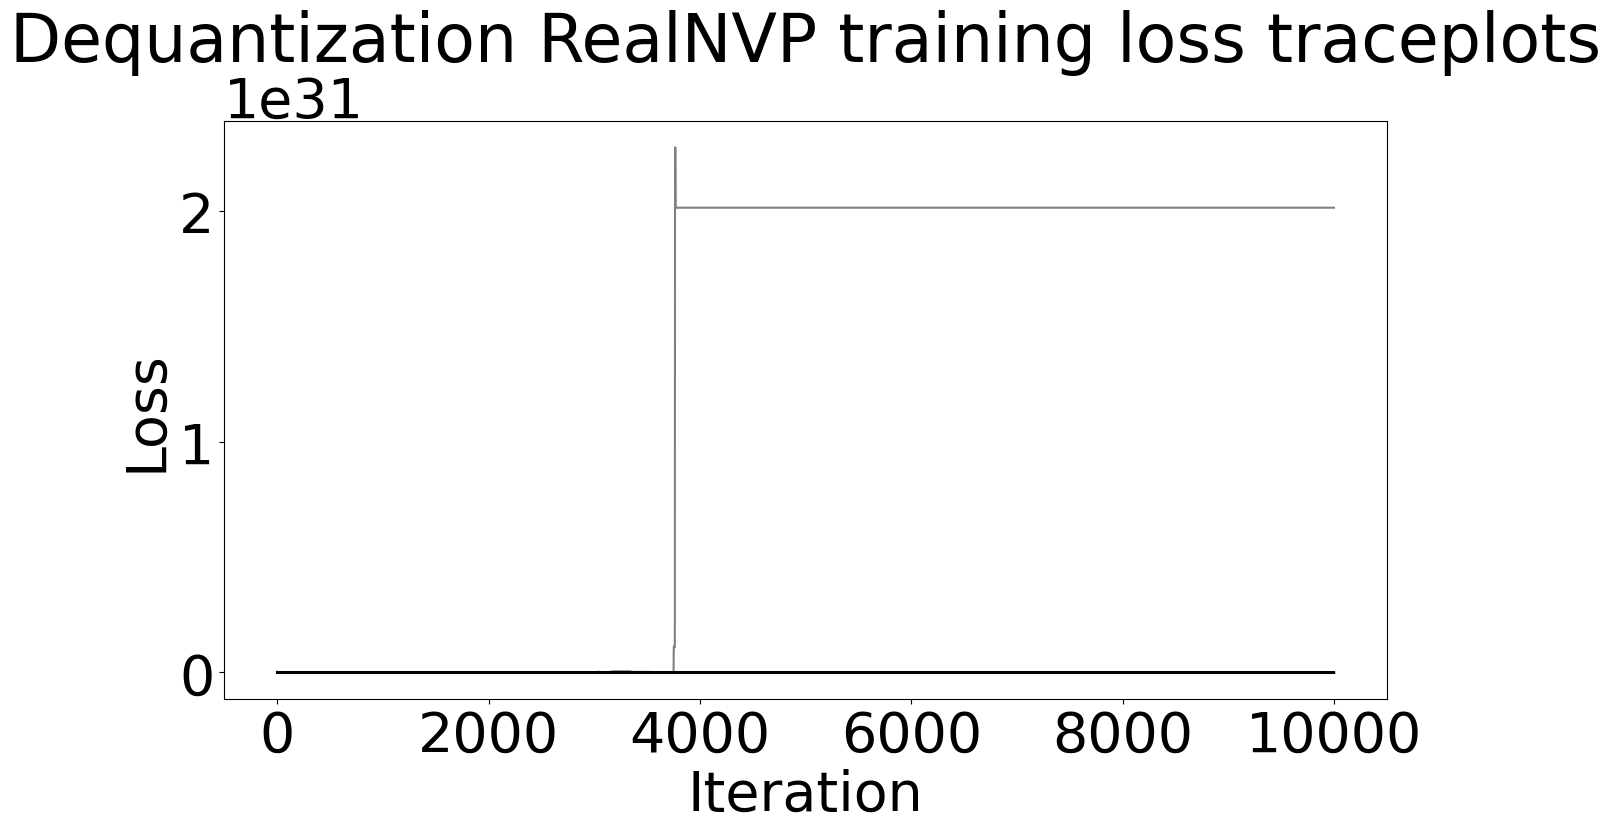

In [10]:
# loss traceplot
threshold=np.inf
for i in range(dequant_sim_size_prst): plt.plot(np.arange(dequant_max_iters_prst)[dequant_losses_prst[i,:]<threshold],dequant_losses_prst[i,dequant_losses_prst[i,:]<threshold],'-k',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Dequantization RealNVP training loss traceplots')

In [35]:
#########################
#########################
# get samples and elbos #
#########################
#########################
torch.manual_seed(1)
sample_size=1000
Kp=int(K+3+K)
dequant_samples_prst=np.zeros((dequant_sim_size_prst,sample_size,Kp))
dequant_densities_prst=np.zeros((dequant_sim_size_prst,sample_size))
dequant_elbos_prst=-np.inf*np.ones(dequant_sim_size_prst)

for i in range(dequant_sim_size_prst):
    print(str(i+1)+'/'+str(dequant_sim_size_prst),end='\r')
    tmp_flow=dequant_flows_prst[i]
    if isinstance(tmp_flow, int): continue
    
    try:
        # generate sample
        tmp_sample=tmp_flow.sample(sample_size)
        dequant_samples_prst[i,:,:] = tmp_sample.detach().numpy()
    
        # unpack and quantize sample
        xd,xc = dequantization.sas_unpack_torch(tmp_sample.T,K)
        thetau,tau2u,sigma2u,beta = dequantization.sas_unflatten_torch(xc)
        theta,tau2,sigma2 = dequantization.sas_constrain_torch(thetau,tau2u,sigma2u)
        theta,tau2,sigma2=theta.detach().numpy(),tau2.detach().numpy(),sigma2.detach().numpy()
        beta = beta.detach().numpy()
        pi = np.floor(xd.detach().numpy()).astype(int)
        pi[pi<0] = 0
        pi[pi>1] = 1
    
        # compute density
        t0=time.perf_counter()
        dequant_densities_prst[i,:]=tmp_flow.log_prob(tmp_sample).detach().numpy()
        dequant_densitycput[0,i]=time.perf_counter()-t0
    
        # estimate elbo
        llp = sas_lposterior(pi,theta,tau2,sigma2,beta,prst_dat_x,prst_dat_y)
        dequant_elbos_prst[i]=-np.mean(np.ma.masked_invalid(dequant_densities_prst[i,:] - llp))
        
    except Exception: continue
# end for
plt.clf()

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_95831/735616984.py:30: RuntimeWarning: invalid value encountered in add
  lp += stats.gamma(a=a1,scale=1./a2).logpdf(sigma2)
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_95831/735616984.py:31: RuntimeWarning: divide by zero encountered in log1p
  lp += np.sum(np.log(theta)*pi + np.log1p(-theta)*(1-pi),axis=0)
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_95831/735616984.py:31: RuntimeWarning: invalid value encountered in multiply
  lp += np.sum(np.log(theta)*pi + np.log1p(-theta)*(1-pi),axis=0)
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_95831/735616984.py:32: RuntimeWarning: invalid value encountered in multiply
  lp += -0.5*K*np.log(2*np.pi*sigma2*tau2)-0.5*np.sum(beta**2,axis=0)/sigma2*tau2
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_95831/735616984.py:32: RuntimeWarning: divide by zero encountered in log
  lp += -0.5*K*np.log(2*np.pi*sigma2*tau2)-0.5*np.sum(beta**2,ax

<Figure size 1500x750 with 0 Axes>

In [36]:
i_star=np.nanargmax(dequant_elbos_prst)
print('Optimal flow: '+str(i_star))

Optimal flow: 10


In [37]:
xd,xc = dequantization.sas_unpack_torch(dequant_flows_prst[i_star].sample(10000).T,K)
thetau,tau2u,sigma2u,beta = dequantization.sas_unflatten_torch(xc)
theta,tau2,sigma2 = dequantization.sas_constrain_torch(thetau,tau2u,sigma2u)
pi = np.floor(xd.detach().numpy()).astype(int)
pi[pi<0] = 0
pi[pi>1] = 1

In [38]:
np.mean(pi,axis=1)

array([0.1574, 0.1289, 0.1125, 0.2242, 0.1415, 0.1305, 0.2026, 0.1278])

In [39]:
torch.mean(beta,axis=1)

tensor([ 0.7938, -0.5948,  0.5366,  0.7691,  0.2087,  1.7800,  0.2437, -1.4048],
       grad_fn=<MeanBackward1>)

## Superconductivity data

In [15]:
spr_dat_raw = pd.read_csv('dat/train.csv')
spr_dat_raw

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


In [16]:
# subsample and rm missing values (code from MixFlows by Xu et al.)
spr_dat_raw = spr_dat_raw.loc[np.random.choice(spr_dat_raw.index, 100, replace=False)]
spr_dat_raw = spr_dat_raw.replace('?', np.nan)
spr_dat_raw = spr_dat_raw.dropna()

In [17]:
# normalize data
spr_dat_x = np.array(spr_dat_raw[spr_dat_raw.columns.difference(['critical_temp'])])
spr_dat_x = (spr_dat_x-np.mean(spr_dat_x,axis=1)[:,None])/np.std(spr_dat_x,axis=1)[:,None]
spr_dat_y = np.array(spr_dat_raw['critical_temp'])
spr_dat_y = (spr_dat_y-np.mean(spr_dat_y))/np.std(spr_dat_y)

In [37]:
# save data
np.savetxt("dat/spr_dat_x.csv", spr_dat_x, delimiter=",")
np.savetxt("dat/spr_dat_y.csv", spr_dat_y, delimiter=",")

### Gibbs sampling

In [27]:
####################
####################
#      setup       #
####################
####################
steps = 5000
burnin_pct = 0.8

In [28]:
####################
####################
#   run sampler    #
####################
####################
seed=1

t0=time.perf_counter()
gpis_spr,gbetas_spr,gthetas_spr,gsigmas2_spr,gtaus2_spr = gibbs.gibbs_sas(
    y=spr_dat_y,x=spr_dat_x,steps=steps,burnin_pct=burnin_pct,seed=seed
)
gibbs_cput[1]=time.perf_counter()-t0

In [32]:
####################
####################
#    save data     #
####################
####################
aux.pkl_save(gpis_spr,'sockeye_run/superconductivity/pred_pi')
aux.pkl_save(gbetas_spr,'sockeye_run/superconductivity/pred_beta')
aux.pkl_save(gthetas_spr,'sockeye_run/superconductivity/pred_theta')
aux.pkl_save(gsigmas2_spr,'sockeye_run/superconductivity/pred_sigma2')
aux.pkl_save(gtaus2_spr,'sockeye_run/superconductivity/pred_tau2')

### MAD Mix

In [261]:
####################
####################
#      setup       #
####################
####################
size = 100
N = 500
L = 15
epsilon = 0.001
xi = np.pi/16
nu2 = 10

# relevant functions
lp = madmix_aux.sas_gen_lp(spr_dat_x,spr_dat_y)
grad_lp = madmix_aux.sas_gen_grad_lp(spr_dat_x,spr_dat_y)
lq0 = madmix_aux.sas_gen_lq0(spr_dat_x,spr_dat_y,nu2)
randq0 = madmix_aux.sas_gen_randq0(spr_dat_x,spr_dat_y,nu2)

In [262]:
RUN=False # to control whether to run or to import saved results

if RUN:
    print('Sampling')
    t0=time.perf_counter()
    xd_,ud_,xc_,rho_,uc_=madmix.randqN(size,N,randq0,L,epsilon,lp,grad_lp,xi)
    madmix_cput[1]=time.perf_counter()-t0
    
    mad_spr_results=madmix_aux.sas_pack(xd_,ud_,xc_,rho_,uc_)
    print('Done!')
    print('Saving sampling results')
    aux.pkl_save(mad_spr_results,'results/mad_spr_results')
    
    print('Evaluating log density')
    mad_lq_spr = madmix.lqN(xd_.astype(int),ud_,xc_,rho_,uc_,N,lq0,L,epsilon,lp,grad_lp,xi)
    print('Saving log density results')
    aux.pkl_save(mad_lq_spr,'results/mad_spr_lq')
    print('Done!')
else:
    print('Importing cached results')
    mad_spr_results=aux.pkl_load('results/mad_spr_results')
    
    print('Importing cached log density')
    mad_lq_spr=aux.pkl_load('results/mad_spr_lq')
    xd_,ud_,xc_,rho_,uc_=madmix_aux.sas_unpack(mad_spr_results,K=spr_dat_x.shape[1])
    print('Done!')
# end if

Importing cached results
Importing cached log density
Done!


In [263]:
# format results
madmix_pi_spr = np.copy(xd_)
thetau,tau2u,sigma2u,madmix_beta_spr = madmix_aux.sas_unflatten(xc_)
madmix_theta_spr,madmix_tau2_spr,madmix_sigma2_spr = madmix_aux.sas_constrain(thetau,tau2u,sigma2u)

In [264]:
# calculate ELBO
lp = sas_lposterior(madmix_pi_spr,madmix_theta_spr,madmix_tau2_spr,madmix_sigma2_spr,madmix_beta_spr,
                    spr_dat_x,spr_dat_y)
madmix_elbos[1] = np.nanmean(mad_lq_spr-lp)

### Mean-field

In [200]:
####################
####################
#   import data    #
####################
####################
mf_spr_results = np.genfromtxt('results/mf_spr_results.csv', 
                                delimiter=",",
                                skip_header=1)

In [214]:
mf_elbos[1]=meanfield_sas_elbo(B=10000,mu=mf_spr_results[:,0],sigma=mf_spr_results[:,1],pi=mf_spr_results[:,2],
            nu=10.,x=spr_dat_x,y=spr_dat_y)

## Save results

In [266]:
# MAD Mix
aux.pkl_save(madmix_elbos, '../summary/results/madmix_elbos_sas')
aux.pkl_save(madmix_cput, '../summary/results/madmix_cput_sas')

# Gibbs
aux.pkl_save(gibbs_cput, '../summary/results/gibbs_cput_sas')

# mean field
mf_cput = np.genfromtxt('results/mf_cput.csv', 
                                delimiter=",",
                                skip_header=1)
aux.pkl_save(mf_cput, '../summary/results/meanfield_cput_sas')
aux.pkl_save(mf_elbos, '../summary/results/meanfield_elbos_sas')